In [39]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

#from gensim.models import Word2Vec
#from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


stopwords = set(stopwords.words('english'))
symbols   = ['.', ',', '’','“','”','"', "''" ,"'",'*','``', '**','$','%','&','#','-','--',"''",'""','?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"'s","'m","n't"]
stopwords.update(symbols)



def remove_urls (source_text):
    url_reg  = r'[a-z]*[:.]+\S+'
    result   = re.sub(url_reg, '', source_text)
    return result

In [42]:
data = pd.read_csv('./2015-2020-Technology.csv')
data = data.dropna()
data = data.reset_index()
for i in range(len(data)):
    data['selftext'].iloc[i] = remove_urls(data['selftext'].iloc[i])

/Library/Python/3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [44]:
print("Total available data :",len(data))
filtered_title = []
filtered_content = []
lemmatizer = WordNetLemmatizer()
for title, content in zip(data['title'], data['selftext']):
    filtered_title.append([lemmatizer.lemmatize(word, pos="n") for word in word_tokenize(title.lower()) if word not in stopwords])
    filtered_content.append([lemmatizer.lemmatize(word, pos="n")  for word in word_tokenize(content.lower()) if word not in stopwords])


Total available data : 3107


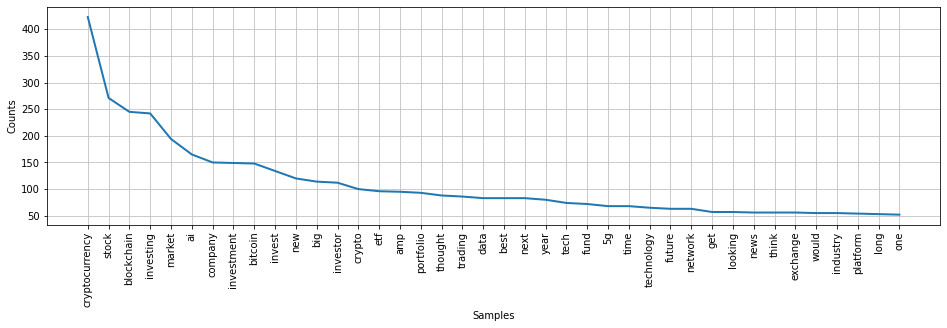

In [45]:
# Word frequency for Title
all_filtered_title = sum(filtered_title, [])
fdist_title = nltk.FreqDist(all_filtered_title)
plt.figure(figsize=(16,4))
fdist_title.plot(40,cumulative=False)

In [46]:
df_title = pd.DataFrame.from_dict(fdist_title, orient='index')
df_title.columns = ['Counts']
df_title = df_title.sort_values(by=['Counts'], ascending=False)
df_title.head()

Counts
cryptocurrency     423
stock              271
blockchain         245
investing          242
market             194

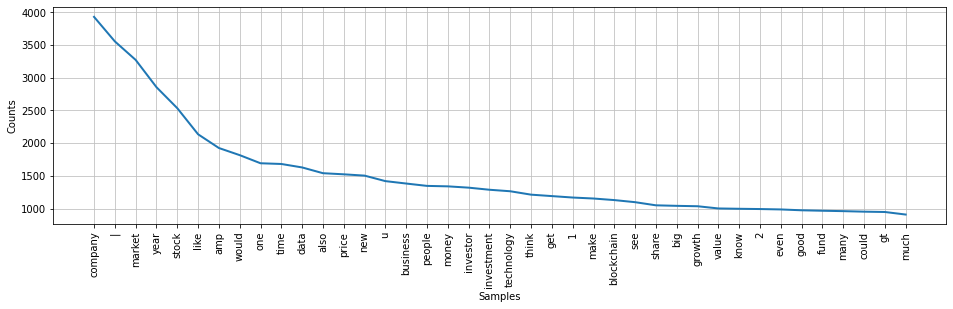

In [47]:
# Word frequency for content
all_filtered_content = sum(filtered_content, [])
fdist_content = nltk.FreqDist(all_filtered_content)
plt.figure(figsize=(16,4))
fdist_content.plot(40,cumulative=False)

In [48]:
df_content = pd.DataFrame.from_dict(fdist_content, orient='index')
df_content.columns = ['Counts']
df_content = df_content.sort_values(by=['Counts'], ascending=False)
df_content.head()

Counts
company    3931
|          3556
market     3273
year       2856
stock      2535

In [52]:
collection = all_filtered_title

In [59]:
garbage_keyword = []
for i in collection:
    if len(i) < 3:
        garbage_keyword.append(i)
garbage_keyword = list(dict.fromkeys(garbage_keyword))

In [62]:
each_words = nltk.FreqDist(collection)
each_words.values()
EachWords = pd.DataFrame.from_dict(each_words, orient='index', columns=['count'])
EachWords = EachWords.sort_values(by=['count'], ascending=False)
temp = EachWords['count'] > 5 # 取出出現次數大於5的單詞

In [64]:
temp.value_counts()

False    4149
True      693
Name: count, dtype: int64

In [65]:
keywords = EachWords[:694].reset_index()

In [66]:
# 統計原始資料的Title中，關鍵字出現的次數，建立稀疏矩陣
def reddit(text, stopword_list):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word.lower(),pos = 'n') for word in word_tokenize(str(text).lower()) if word not in stopword_list]

data['title_embedded'] = data['selftext'].apply(lambda text:reddit(text, stopwords))

In [67]:
data_list = data['title_embedded']

def creat_matrix(list_):
    output = []
    for i in list(keywords['index']):
        if i in list_:
            count = 0
            for j in list_:
                if j == i:
                    count += 1
            output.append(count)
            continue
        output.append(0)
    return output

In [69]:
data_list1 = data_list.apply(creat_matrix)
data_matrix = pd.DataFrame(list(data_list1), columns=list(keywords['index']))
data_matrix.head()

cryptocurrency  stock  blockchain  investing  market  ai  company  \
0               0      1           0          0       1   0        0   
1               0      0           0          0       0   0        0   
2               0      0           0          0       0   0        0   
3               0      0           0          0       0   0        0   
4               0      0           0          0       0   0        0   

   investment  bitcoin  invest  ...  buffett  cheap  past  morgan  warren  \
0           0        0       0  ...        0      0     0       0       0   
1           0        0       0  ...        0      0     0       0       0   
2           0        0       1  ...        0      0     0       0       0   
3           0        0       0  ...        0      0     0       0       0   
4           0        0       1  ...        0      0     0       0       0   

   raising  leverage  similar  marketing  dump  
0        0         0        0          0     0  
1        0         0        0          0     0  
2        0         0        0          0     0  
3        0         0        0          0     0  
4        0         0        0          0     0  

[5 rows x 694 columns]

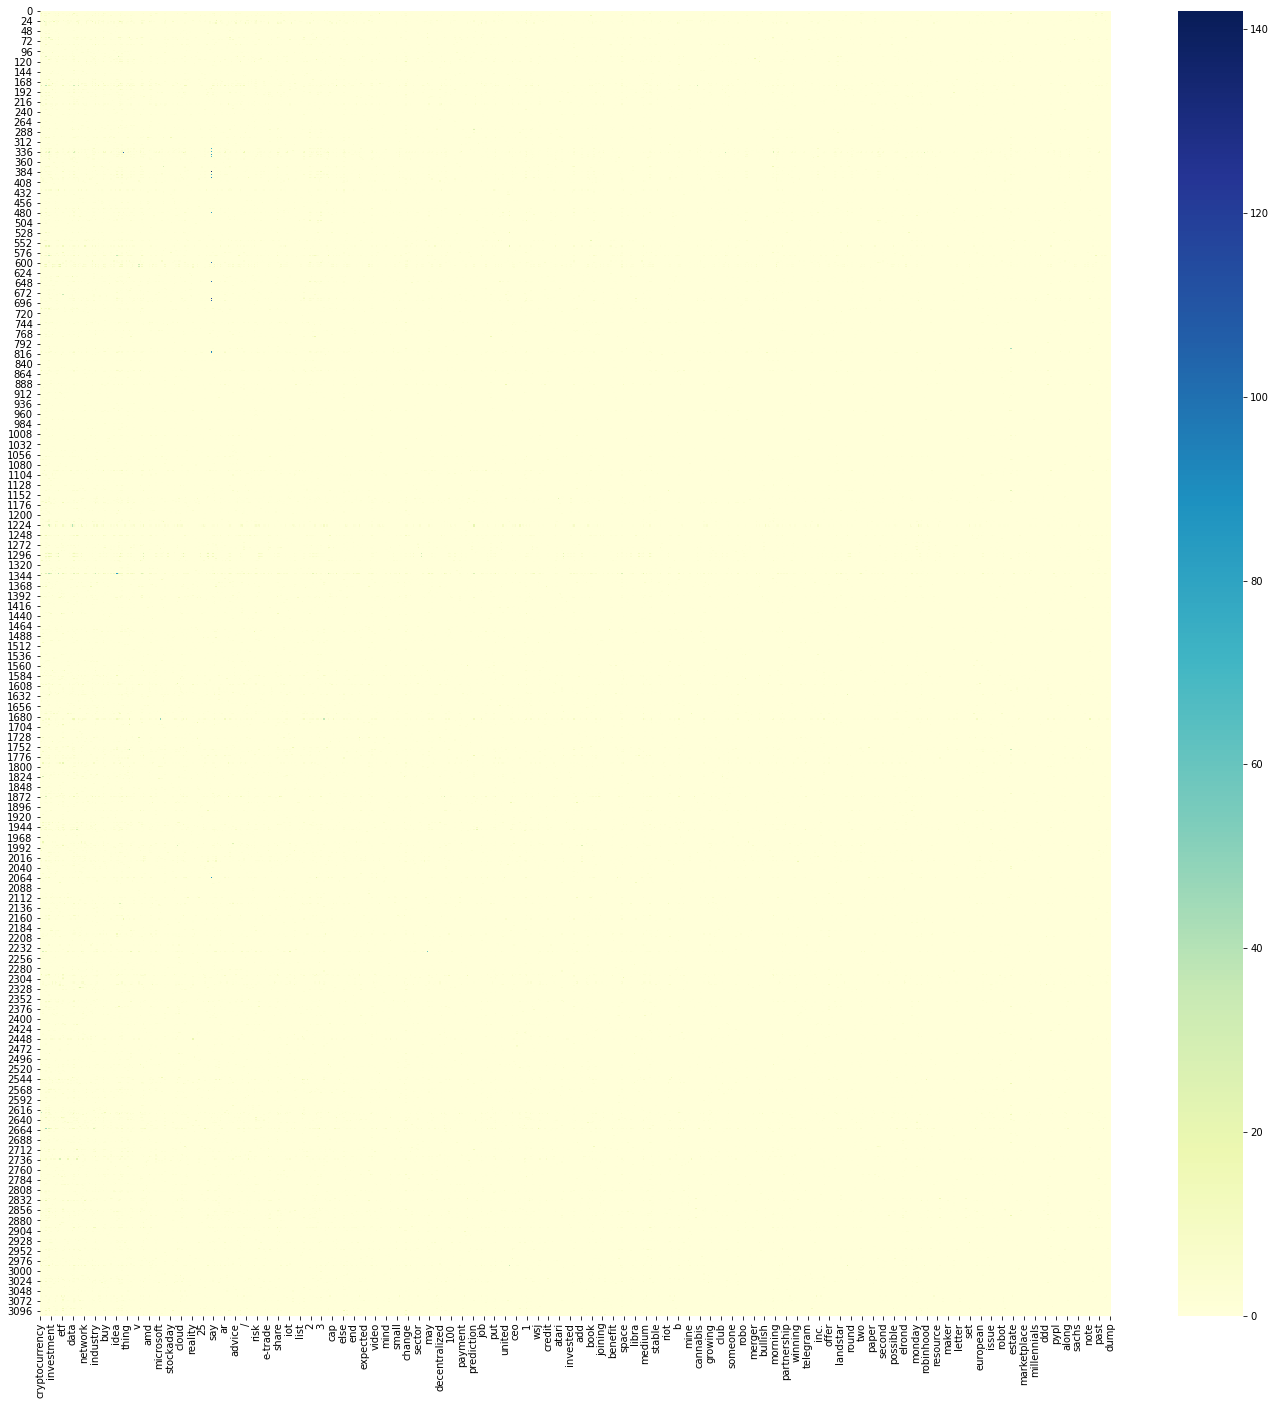

In [70]:
plt.figure(figsize=(24,24))
sns.heatmap(data_matrix, cmap='YlGnBu')
plt.show()

In [71]:
data_matrix_T = data_matrix.transpose()
co_matrix = data_matrix_T.dot(data_matrix)
co_matrix.head()

cryptocurrency  stock  blockchain  investing  market    ai  \
cryptocurrency            1934    588         981        488    1444    67   
stock                      588  21187         364       3082   12347   815   
blockchain                 981    364        8116        357    2366   212   
investing                  488   3082         357       3862    3554   227   
market                    1444  12347        2366       3554   30219  1157   

                company  investment  bitcoin  invest  ...  buffett  cheap  \
cryptocurrency      668         707     1150     456  ...       19     15   
stock             15057        3755      747    1181  ...     1234    583   
blockchain         2322         782     1816     231  ...        2     10   
investing          4248        1477      599    1486  ...      519     87   
market            20218        6298     2467    1802  ...     1216    702   

                past  morgan  warren  raising  leverage  similar  marketing  \
cryptocurrency   116      31      17        6        13       51         46   
stock           2083      87     904       44       257      627        125   
blockchain       165      81       0        5       183      133        156   
investing        607      23     390       29        75      226         39   
market          2810     163     926      719       424     1120        365   

                dump  
cryptocurrency    17  
stock            123  
blockchain         3  
investing         45  
market           118  

[5 rows x 694 columns]

In [123]:
# 資料正規
co_matrix_norm = np.divide(co_matrix, np.diagonal(co_matrix))
co_matrix_norm.head()

/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


cryptocurrency     stock  blockchain  investing    market  \
cryptocurrency        1.000000  0.027753    0.120872   0.126359  0.047785   
stock                 0.304033  1.000000    0.044850   0.798032  0.408584   
blockchain            0.507239  0.017180    1.000000   0.092439  0.078295   
investing             0.252327  0.145467    0.043987   1.000000  0.117608   
market                0.746639  0.582763    0.291523   0.920249  1.000000   

                      ai   company  investment   bitcoin    invest  ...  \
cryptocurrency  0.038528  0.014429    0.113556  0.161835  0.249863  ...   
stock           0.468660  0.325240    0.603116  0.105122  0.647123  ...   
blockchain      0.121909  0.050157    0.125602  0.255559  0.126575  ...   
investing       0.130535  0.091759    0.237231  0.084295  0.814247  ...   
market          0.665325  0.436721    1.011564  0.347171  0.987397  ...   

                 buffett     cheap      past    morgan    warren   raising  \
cryptocurrency  0.026027  0.049020  0.081575  0.553571  0.062271  0.035294   
stock           1.690411  1.905229  1.464838  1.553571  3.311355  0.258824   
blockchain      0.002740  0.032680  0.116034  1.446429  0.000000  0.029412   
investing       0.710959  0.284314  0.426864  0.410714  1.428571  0.170588   
market          1.665753  2.294118  1.976090  2.910714  3.391941  4.229412   

                leverage   similar  marketing      dump  
cryptocurrency  0.074713  0.128463   0.220096  0.548387  
stock           1.477011  1.579345   0.598086  3.967742  
blockchain      1.051724  0.335013   0.746411  0.096774  
investing       0.431034  0.569270   0.186603  1.451613  
market          2.436782  2.821159   1.746411  3.806452  

[5 rows x 694 columns]

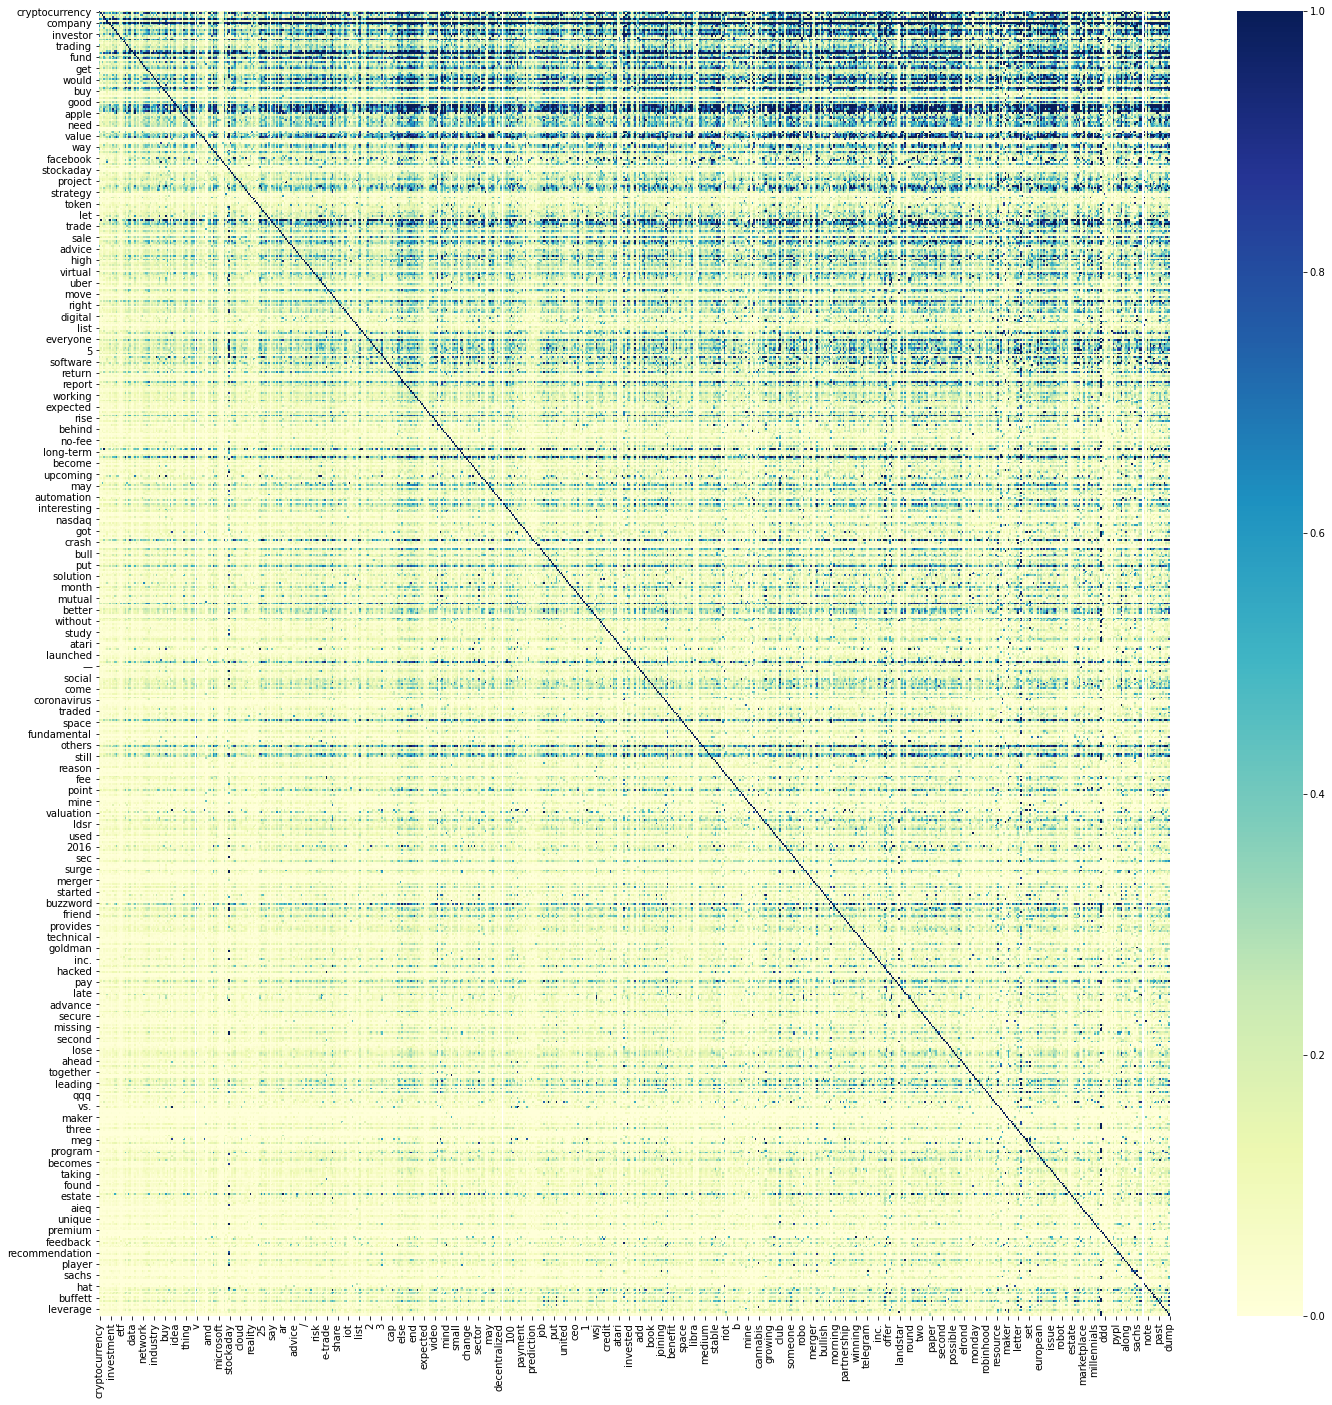

In [124]:
plt.figure(figsize=(24,24))
sns.heatmap(co_matrix_norm, vmin=0, vmax=1, cmap='YlGnBu')
plt.show()

In [80]:
corr = []
for col in co_matrix_norm.columns:
    for row in co_matrix_norm.columns:
        if co_matrix_norm[col][row] > 0:
            corr.append((col, row, co_matrix_norm.loc[col][row]))

In [81]:
graph = nx.Graph()
graph.add_weighted_edges_from(corr)

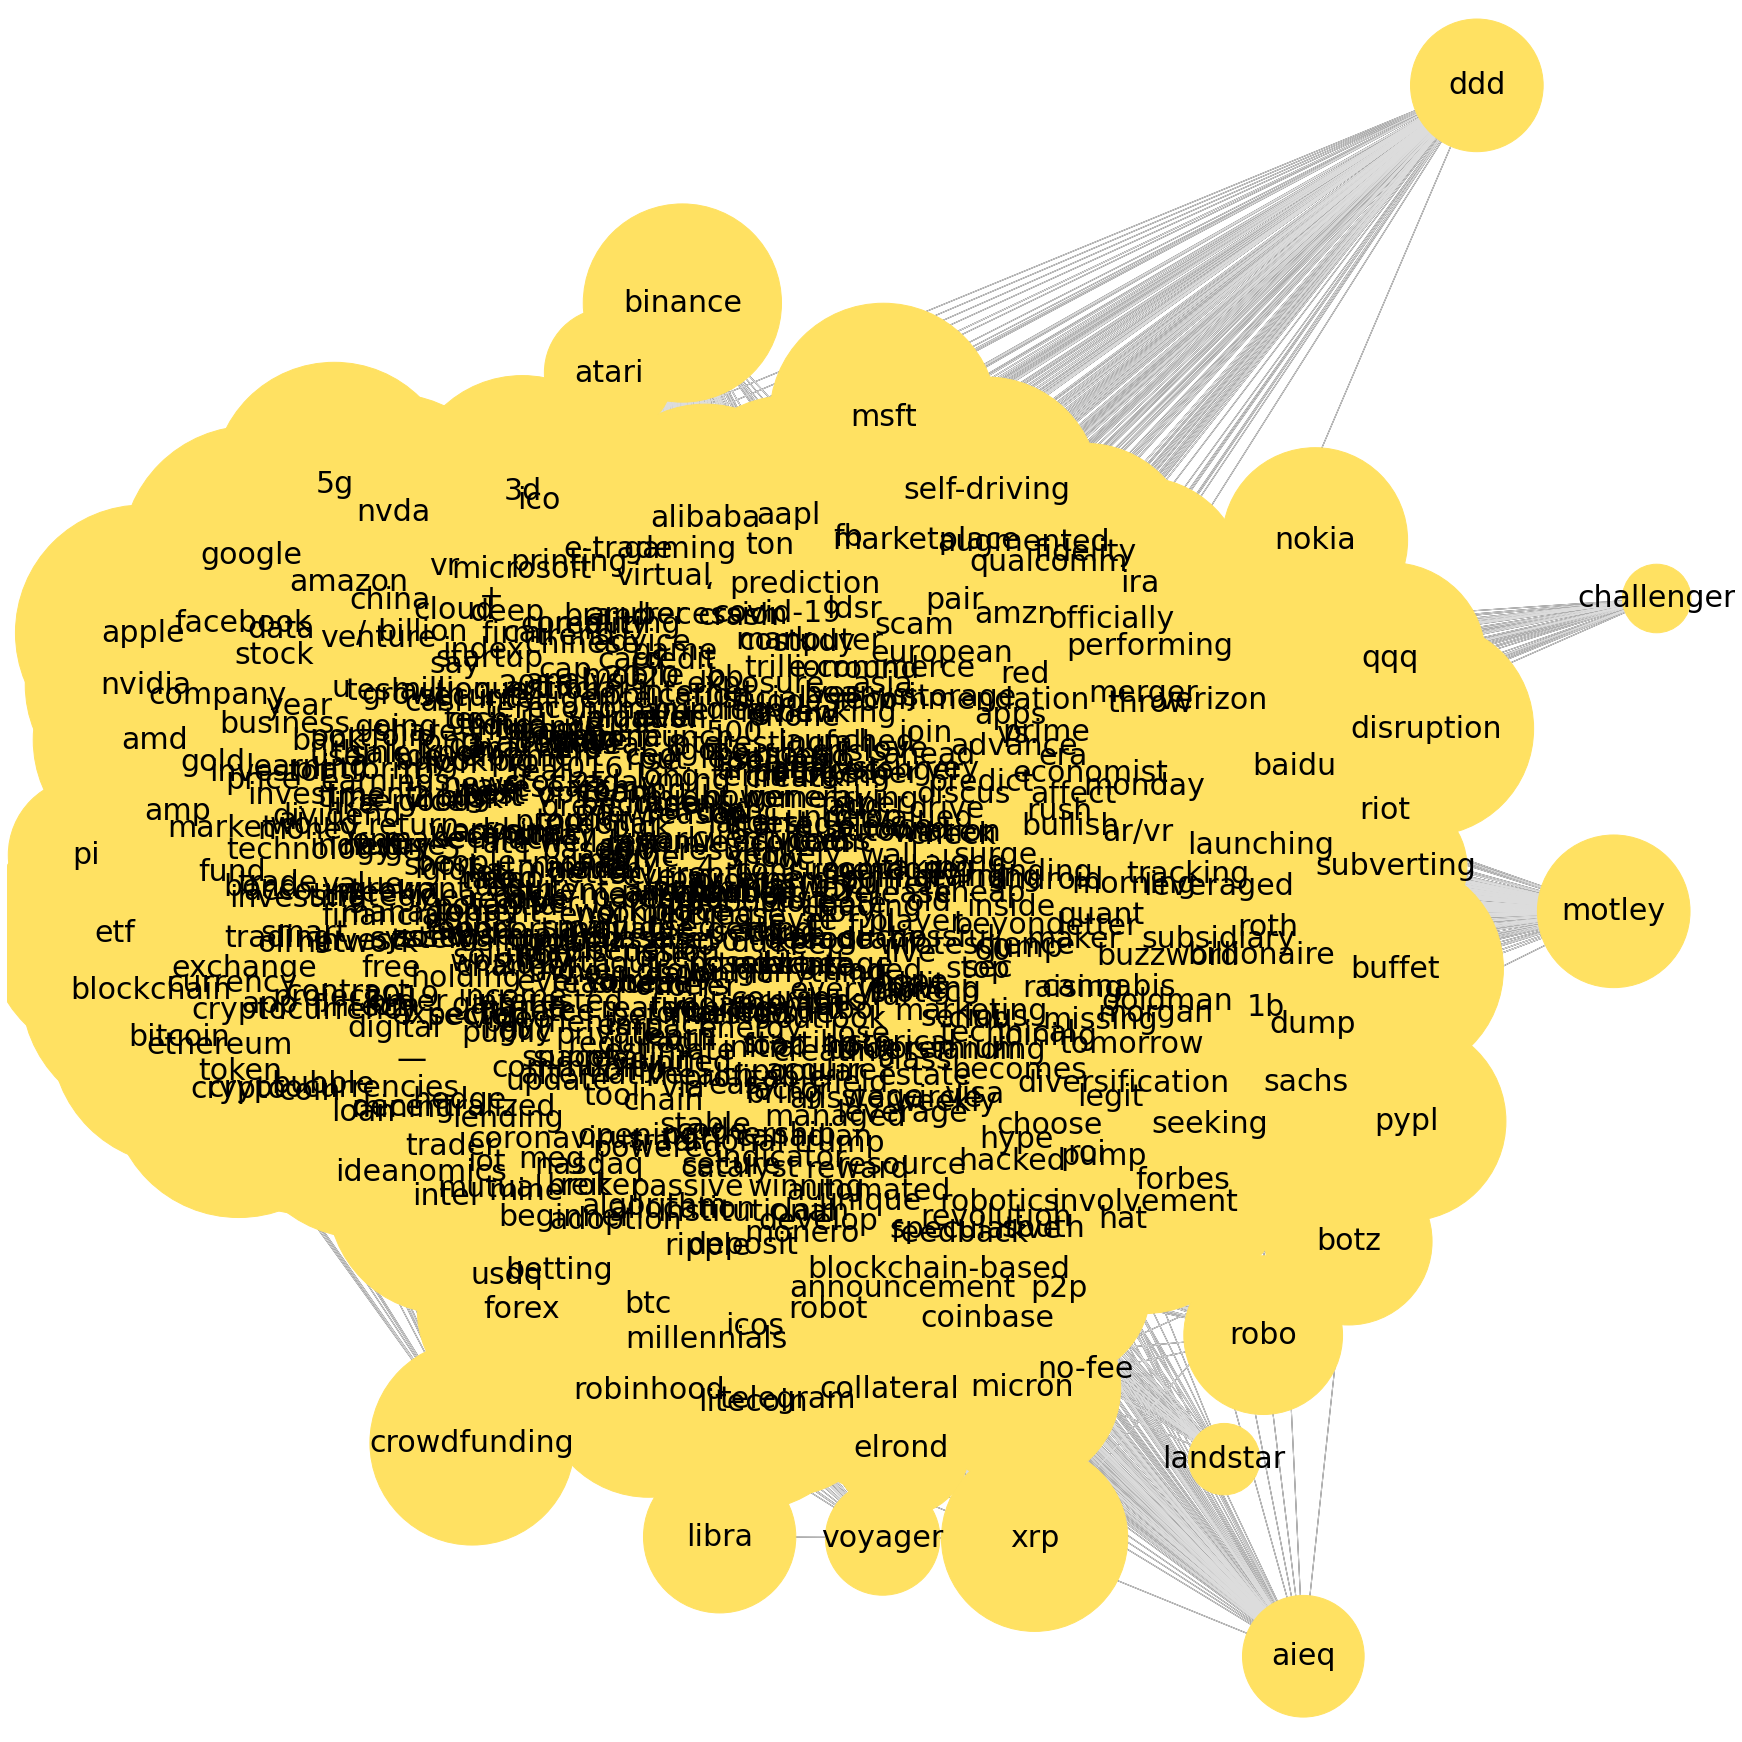

In [82]:
plt.figure(figsize=(24,24))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_size = [val*100 for (node, val) in graph.degree()],node_color = '#FFE162')
nx.draw_networkx_labels(graph, pos, font_size = 30,alpha = 1)
nx.draw_networkx_edges(graph, pos, edge_color = '#DDDDDD', alpha = 1)
# plt.show()

In [91]:
freq = np.diagonal(co_matrix)
freq = pd.DataFrame(freq, co_matrix.index, columns=['freq'])
notexist = freq[freq['freq']==0]
freq = freq.drop(index=notexist.index)


freq_top10 = freq.sort_values(by='freq')

In [106]:
pf = freq_top10[-20:-1]


<BarContainer object of 19 artists>

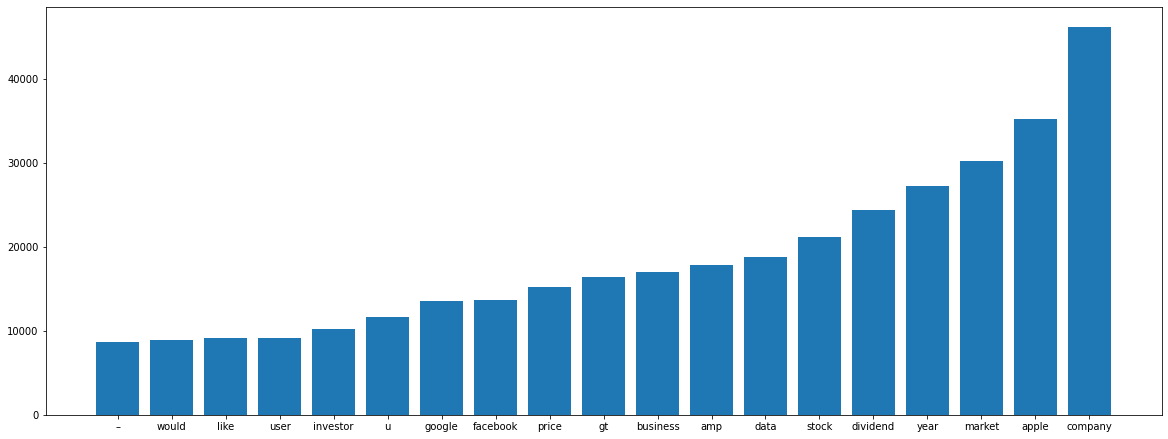

In [108]:
plt.figure(figsize=(20,7.5))
plt.bar(pf.index,pf['freq'].values)

In [190]:
def co_map_edge(symbolId, gap):
    co_edge_symbolId = []
    weight=[]
    row = co_matrix_norm.loc['%s'%symbolId]
    for j in co_matrix_norm.index:
        if row[j]==1:
            weight.insert(0,1)
        else:
            if row[j] >= gap:
                co_edge_symbolId.append(('%s'%symbolId,j,row[j]*1000))
                weight.append(row[j])
    return co_edge_symbolId, weight

In [191]:
def graph_one(C,symbolId,freq):
    plt.figure(figsize=(50,50))
    plt.rcParams['font.sans-serif'] = ['SimHei']   
    plt.rcParams['font.family']='sans-serif'
    pos=nx.spring_layout(C)
    nx.draw(C,pos,node_size=freq.values,font_family='sans-serif',node_color='#33FFFF')
    nx.draw_networkx_labels(C, pos, font_size = 10, font_family='sans-serif',alpha=1)
    nx.draw_networkx_edges(C, pos, edge_color='#DDDDDD', alpha=1)
    plt.savefig('%d'%symbolId+'_Co-occurrence map.png')
    plt.show()

In [192]:
def test(keyWord, gap):
    edge, weight = co_map_edge(keyWord, gap)
    freqKeyWord=[freq.loc[keyWord]['freq']]
    for i in edge:
        freqKeyWord.append(freq.loc[i[1]]['freq'])
    graph = nx.Graph()
    graph.add_weighted_edges_from(edge)
    plt.figure(figsize=(24,24))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, node_size = [val*100 for (node, val) in graph.degree()],node_color = '#FFE162')
    nx.draw_networkx_labels(graph, pos, font_size = 30,alpha = 1)
    nx.draw_networkx_edges(graph, pos, edge_color = '#DDDDDD', alpha = 1)

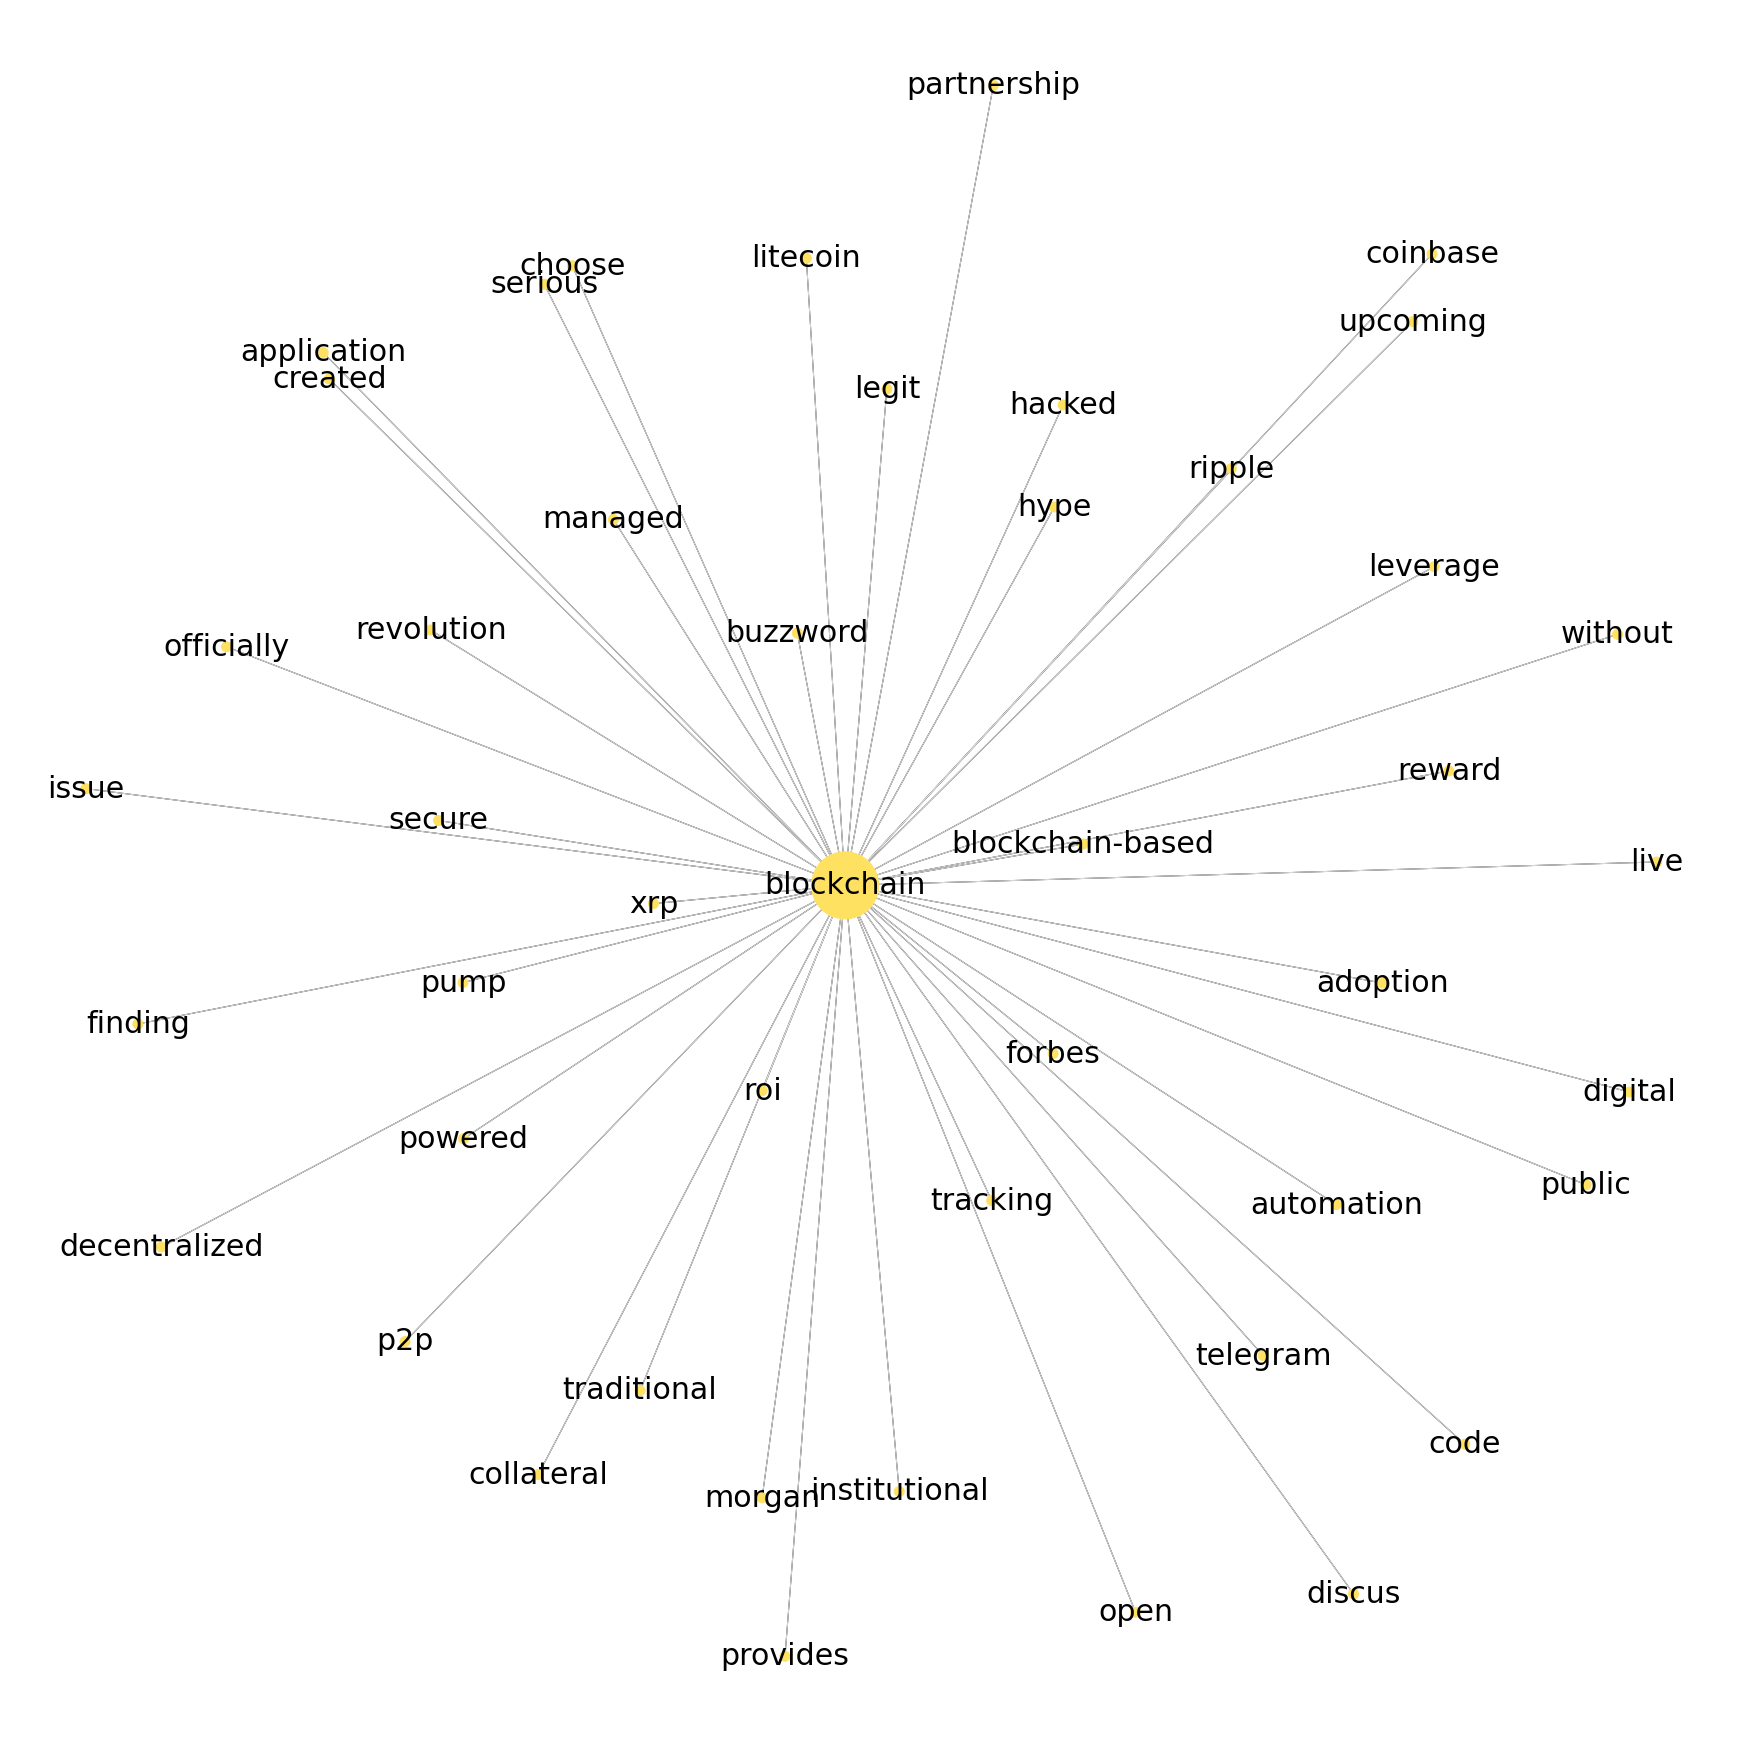

In [195]:
test('blockchain', 1)

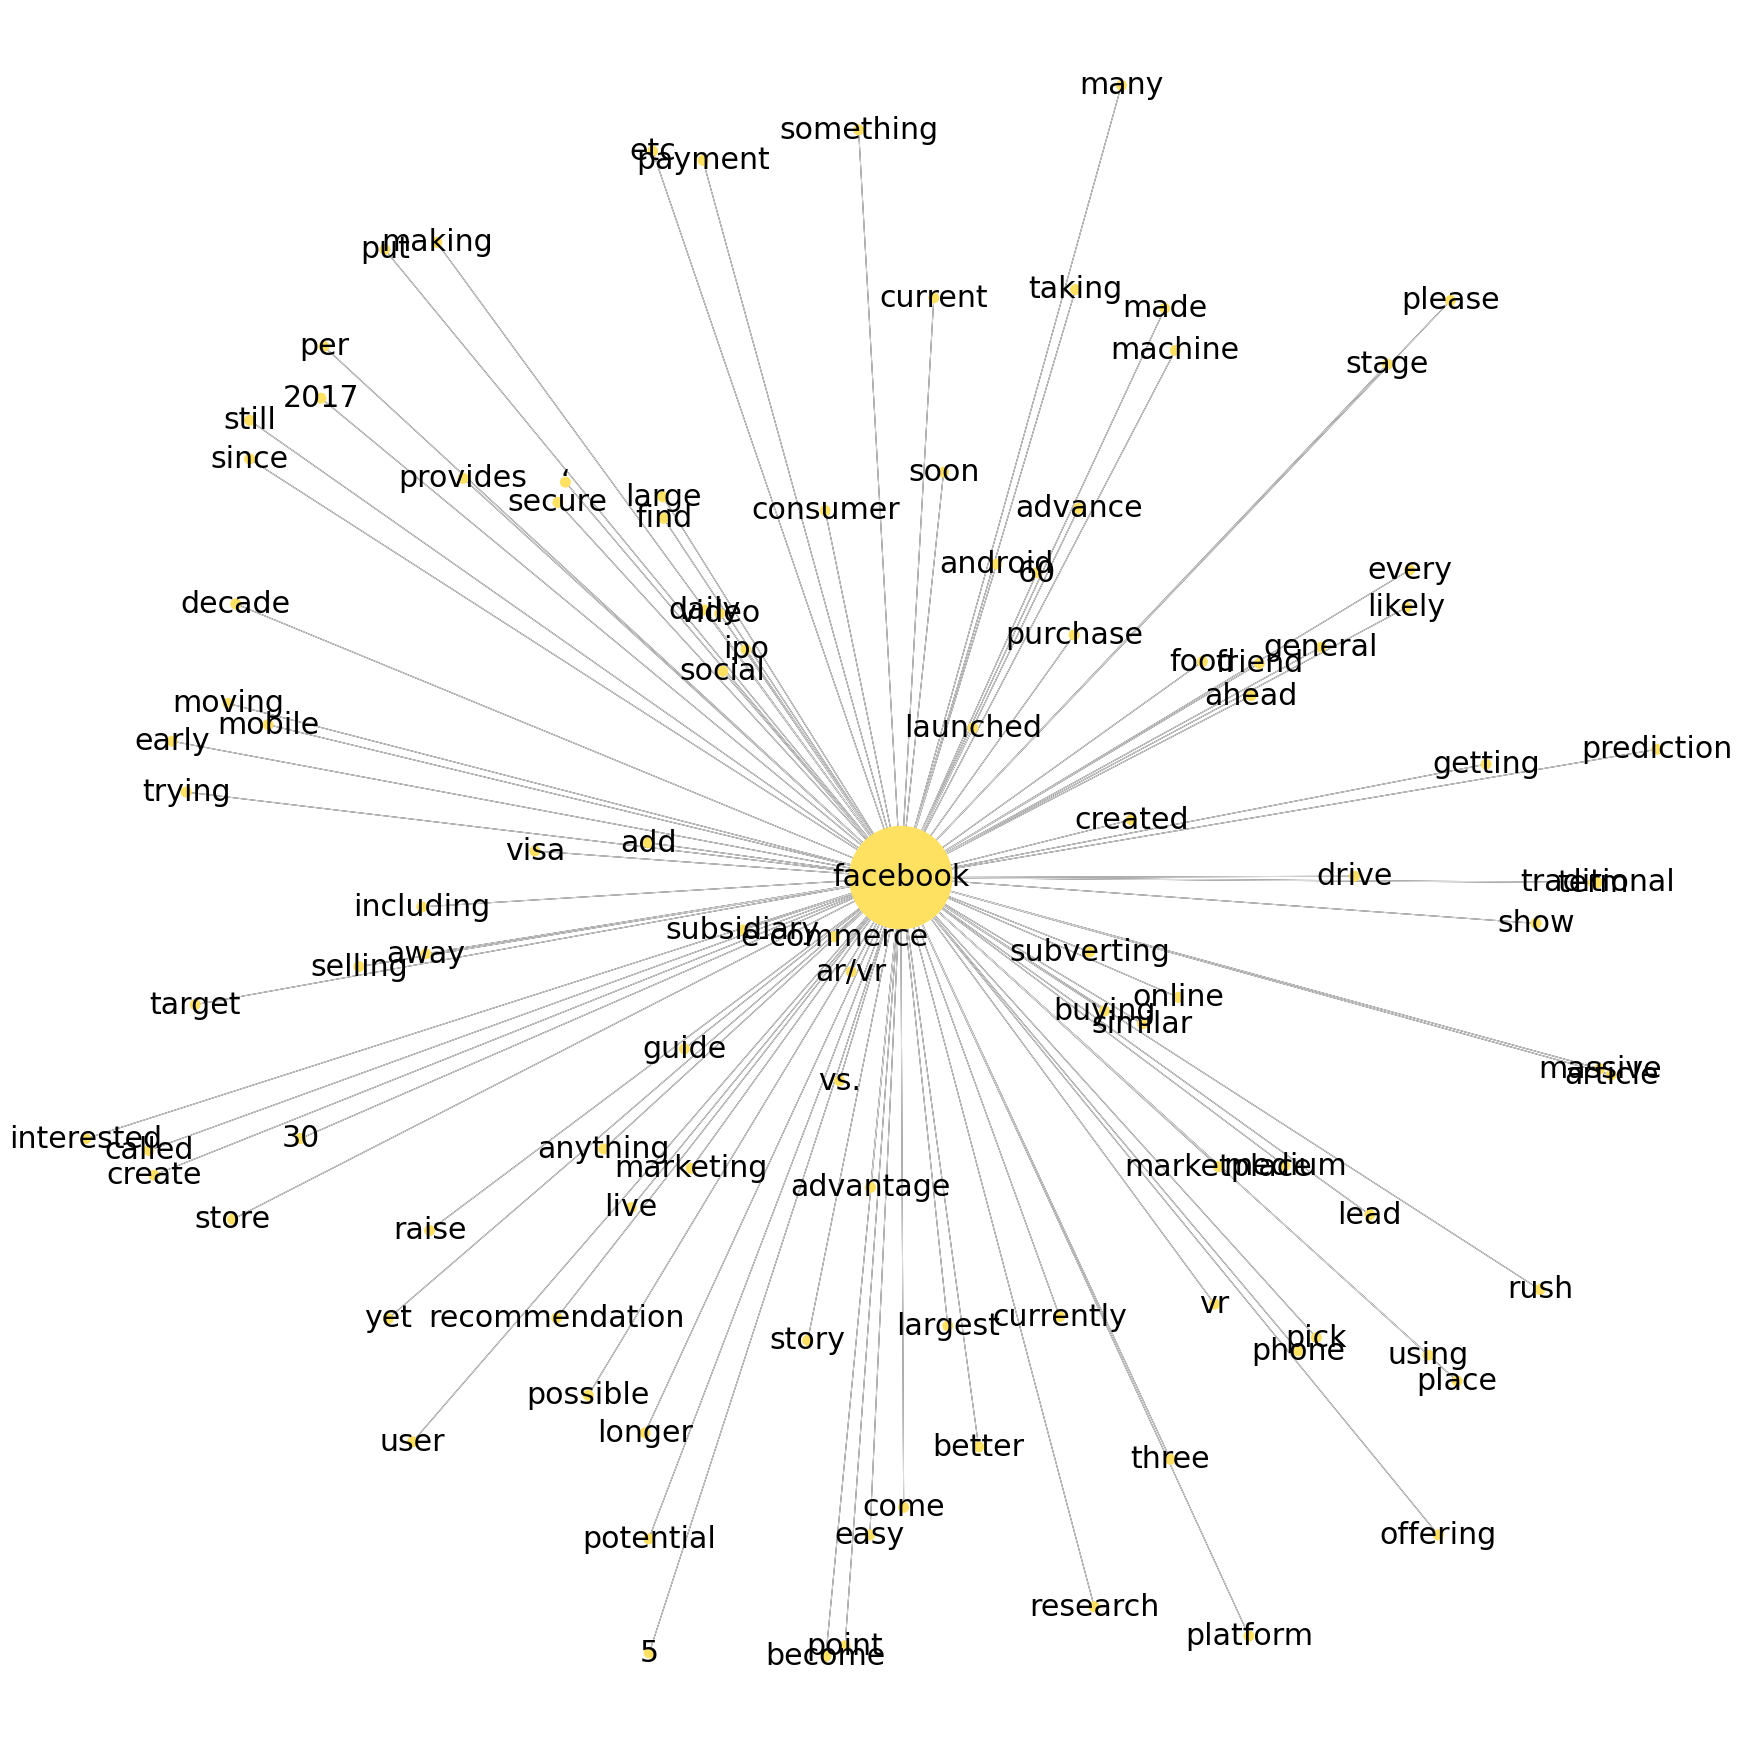

In [218]:
test('facebook', 0.8)

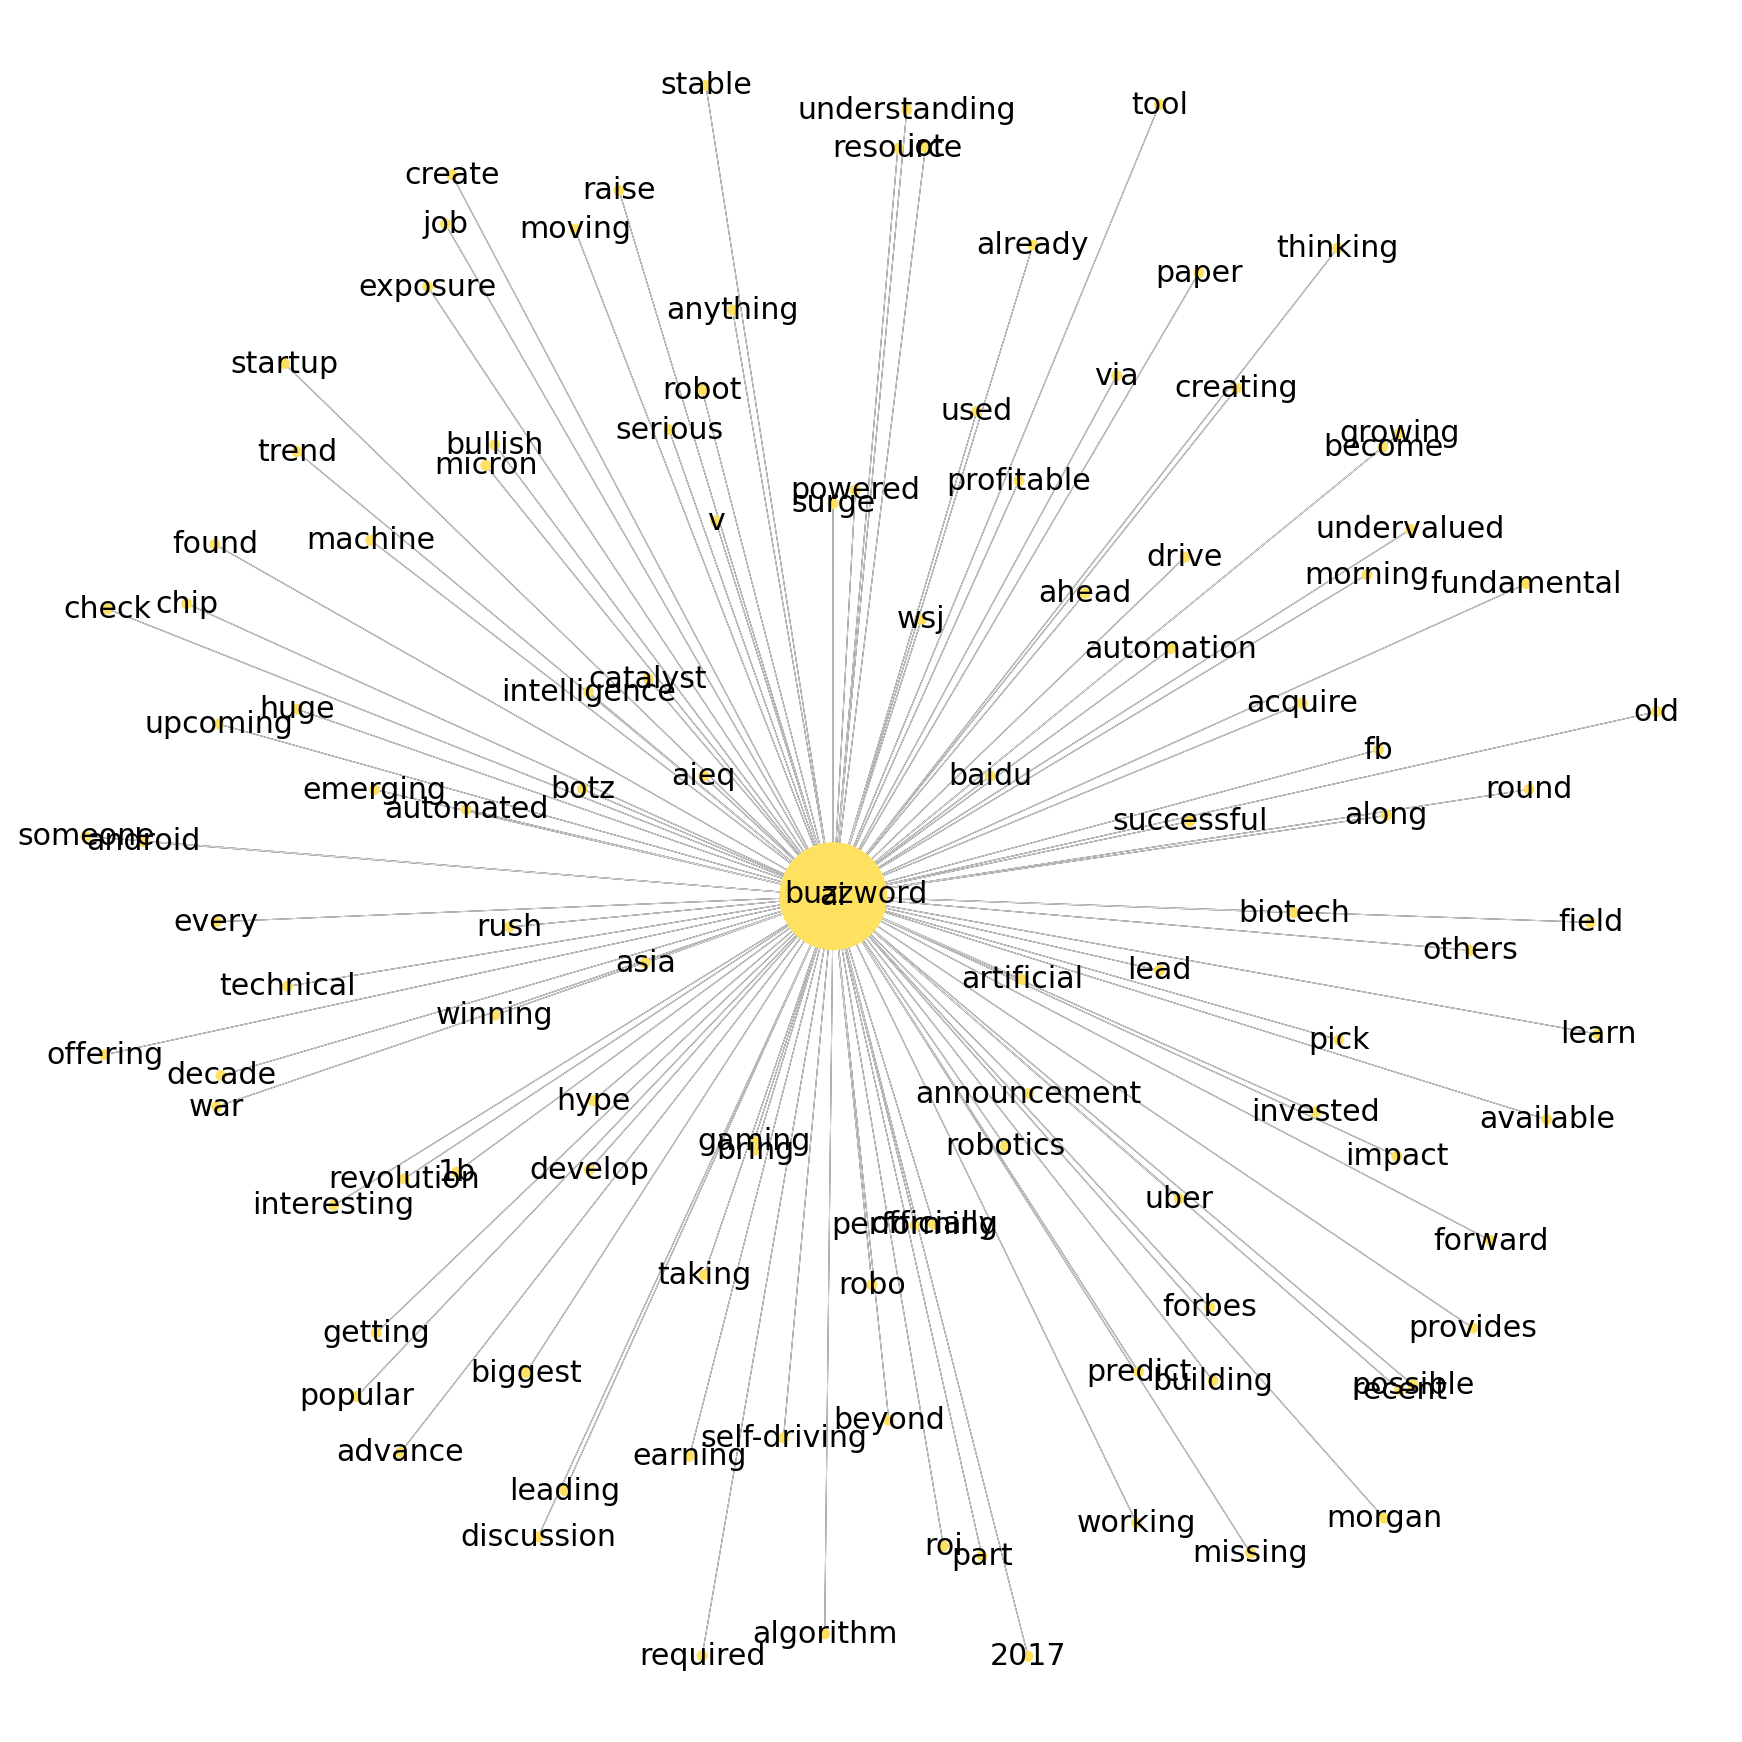

In [200]:
test('ai', 0.25)

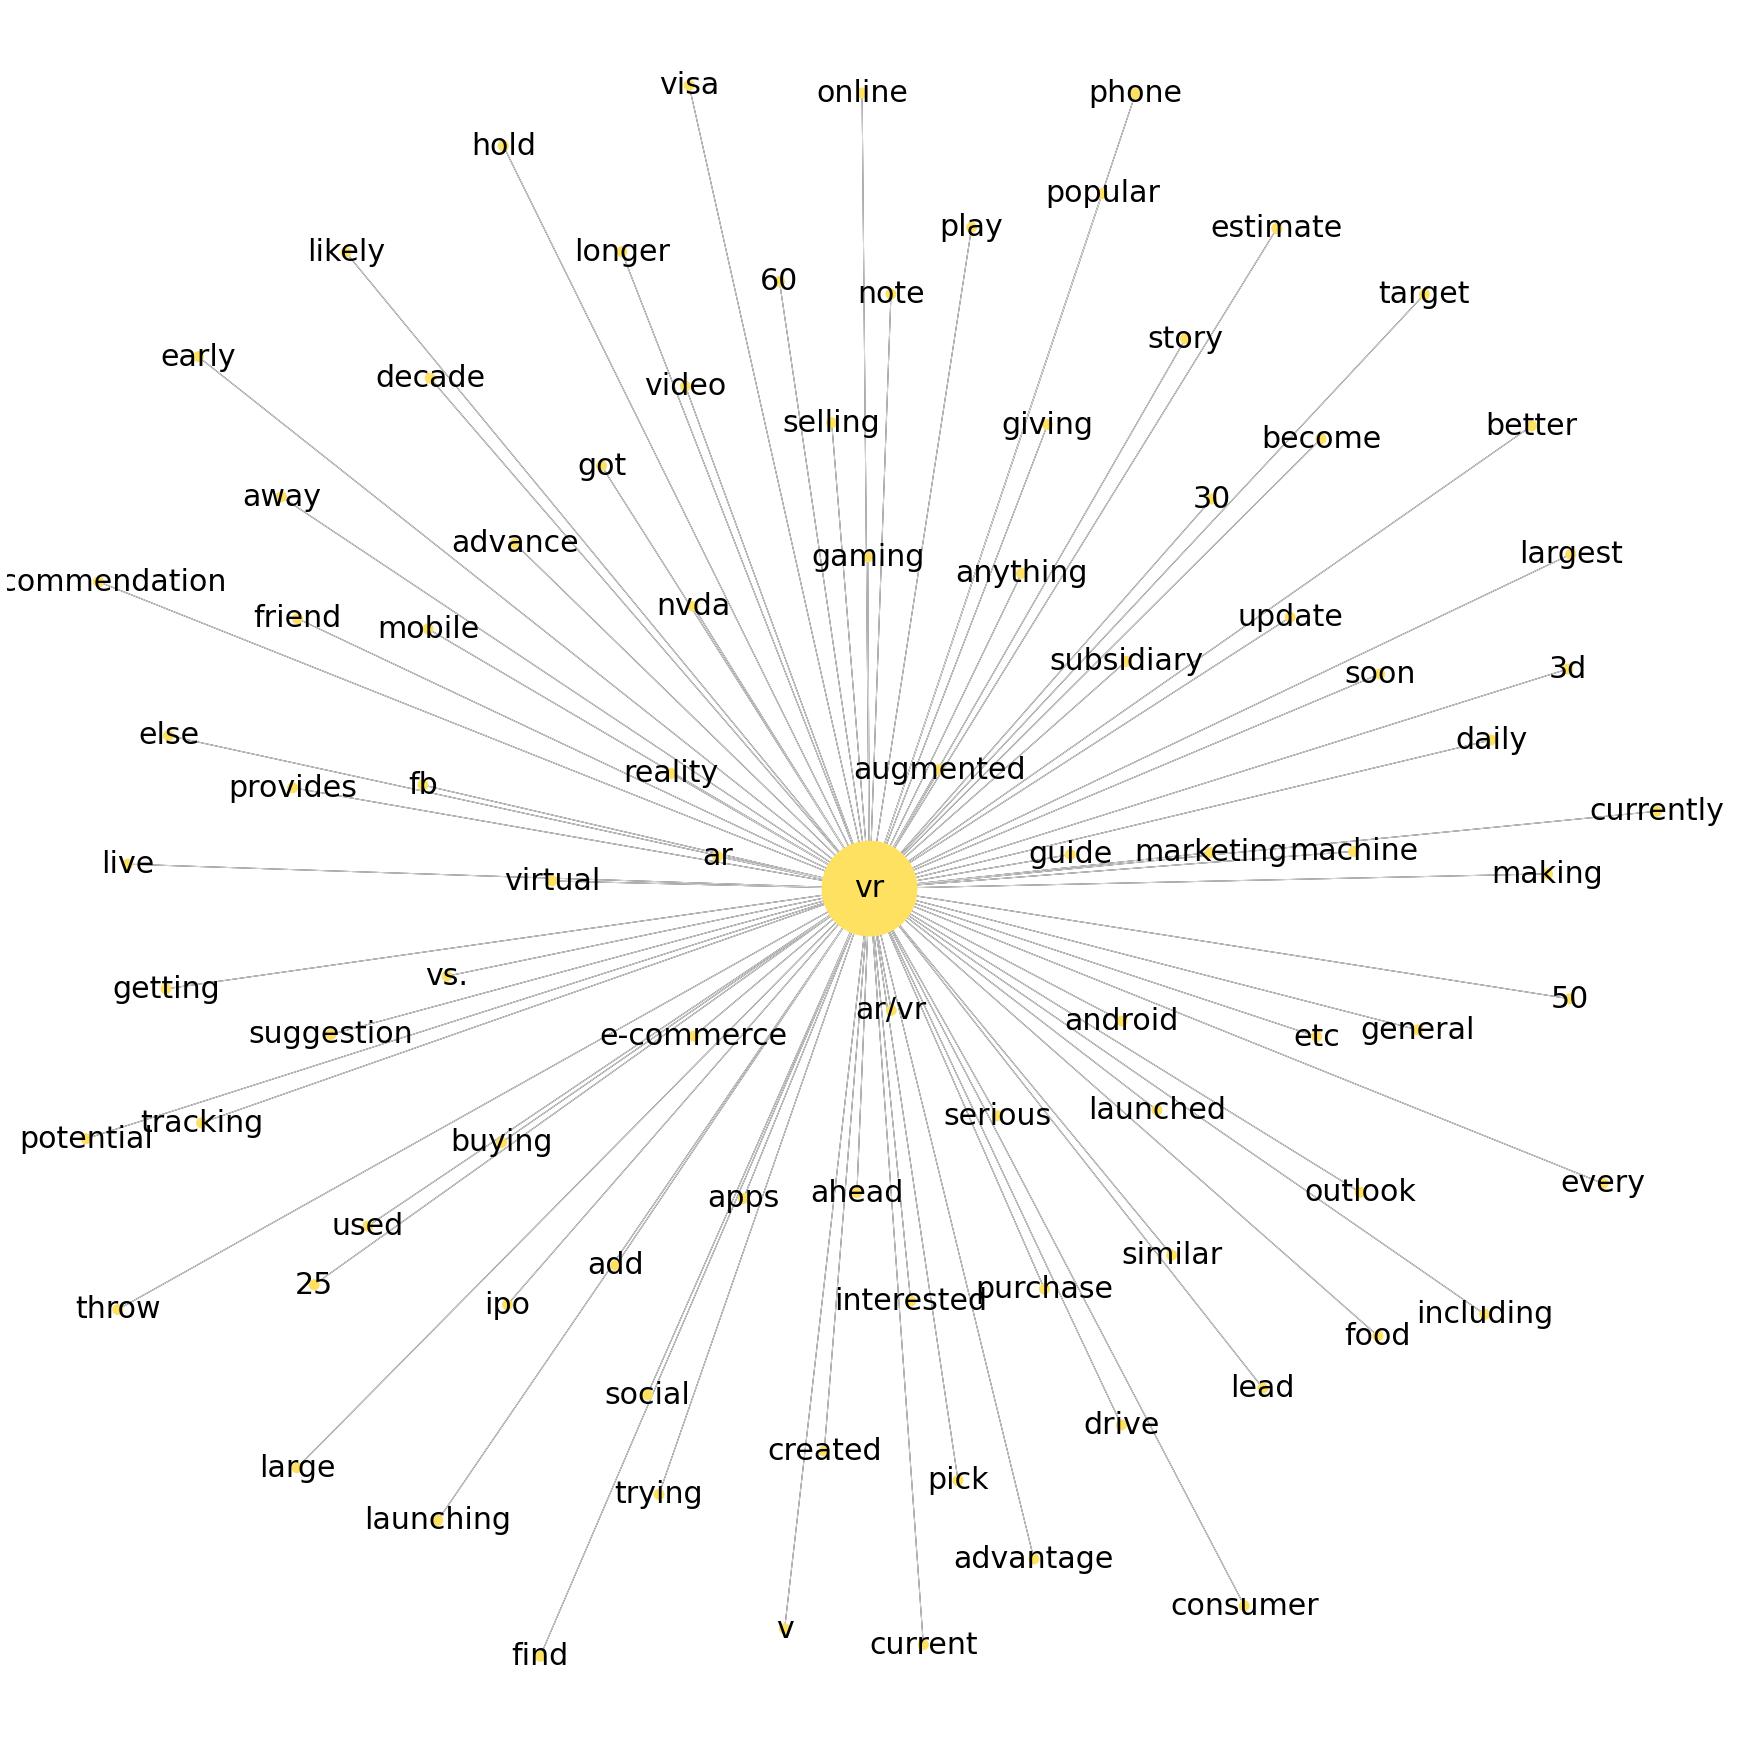

In [206]:
test('vr', 0.1)

In [212]:
freq.sort_values('freq')[-20:-1]

freq
–          8669
would      8899
like       9136
user       9171
investor  10282
u         11632
google    13596
facebook  13641
price     15214
gt        16466
business  16967
amp       17860
data      18769
stock     21187
dividend  24425
year      27266
market    30219
apple     35277
company   46295